This notebook (1) combines all the genus-level OTU tables into one large table, (2) plots the uncorrected PCoA between all samples, and (3) plots the combat-corrected PCoA between all samples

In [15]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

# Add util to the path
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import FileIO as fio
from util import collapse_taxonomic_contents_df

# Add combat to path and import
# Note to Sean: git clone combat.py and replace my path with the path to your combat.py repo
src_dir = os.path.normpath('/Users/claire/github/combat.py')
sys.path.insert(0, src_dir)
import combat

## Read all data and combine into one df

Will also save this file to this folder, so I don't have to re-do it every time.

In [16]:
datadir = '../../data/clean_tables'

In [17]:
# Read in dfdict
dfdict = fio.read_dfdict_data(datadir)

Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller ra_scher ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang mhe_zhang crc_chen ob_turnbaugh hiv_dinh crc_zackular ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [18]:
# Collapse to genus level
for dataset in dfdict:
    # Collapse to genus level and relabel samples with dataset ID
    df = dfdict[dataset]['df']
    df = collapse_taxonomic_contents_df(df, 'genus')
    df.index = [dataset + '-' + i for i in df.index]
    dfdict[dataset]['df'] = df
    
    # Also relabel indices in metadata
    meta = dfdict[dataset]['meta']
    meta.index = [dataset + '-' + i for i in meta.index]
    dfdict[dataset]['meta'] = meta

In [19]:
# Concatenate and save data and corresponding metadata
# ob_zhu and nash_zhu are duplicates, consider only once
# cdi_youngster and t1d_mejialeon have fewer than 10 healthy controls
ignore_datasets = ['ob_zhu', 'cdi_youngster', 't1d_mejialeon']

bigdf = pd.concat([dfdict[d]['df'] for d in dfdict if d not in ignore_datasets])
bigmeta = pd.concat([dfdict[d]['meta'] for d in dfdict if d not in ignore_datasets])
print(bigdf.shape)

(4548, 302)


In [20]:
bigmeta['DiseaseState'].unique()

array(['CIRR', 'H', 'MHE', 'HIV', 'T1D', 'EDD', 'CRC', 'ASD', None, 'PSA',
       'RA', 'UC', 'nonIBD', 'CD', 'IBDundef', 'nonCRC', 'OB', 'OW', 'CDI',
       'nonCDI', 'PAR', ' ', 'nonNASH-OB', 'NASH'], dtype=object)

In [21]:
bigmeta.query('DiseaseState == "H"').shape

(1624, 399)

## Batch-correct healthy samples with combat


In [22]:
healthy_df = bigdf.loc[bigmeta.query('DiseaseState == "H"').index]
batches = [i.split('-')[0] for i in healthy_df.index]

In [23]:
# Remove genera which are all NaN or 0
healthy_df = healthy_df.dropna(how='all', axis=1).fillna(0.0)
healthy_df = healthy_df.loc[:, healthy_df.sum(axis=0) > 0]
healthy_df.shape


(1624, 273)

In [24]:
combat_df = combat.combat(healthy_df.T, batches).T

/Users/claire/github/combat.py/combat.py:80: FutureWarning: iterkv is deprecated and will be removed in a future release, use ``iteritems`` instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iterkv() if inter == True]
found 25 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
/Users/claire/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/claire/github/combat.py/combat.py:159: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sum2 = ((sdat - np.dot(g_new.reshape((g_new.shape[0], 1)), np.ones((1, sdat.shape[1])))) ** 2).sum(axis=1)


Adjusting data


# Make plots

#### PCA first

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca_abun = PCA().fit(healthy_df.values)
pca_abun_vals = pca_abun.transform(healthy_df.values)
pca_combat = PCA().fit(combat_df.values)
pca_combat_vals = pca_combat.transform(combat_df.values)

In [27]:
pca_abun_df = pd.DataFrame({'PC1': pca_abun_vals[:, 0], 
                            'PC2': pca_abun_vals[:, 1], 
                            'dataset': [i.split('-')[0] for i in healthy_df.index]})
pca_combat_df = pd.DataFrame({'PC1': pca_combat_vals[:, 0], 
                              'PC2': pca_combat_vals[:, 1], 
                              'dataset': [i.split('-')[0] for i in combat_df.index]})

In [28]:
# xkcd colors, hopefully this works without seaborn
colorlist = ['blue', 'purple', 'magenta', 'red', 'orange', 'brown', 'yellow', 'green', 'bright green',
             'teal', 'sky blue', 'grey', 'dark green', 'dark purple', 'navy blue', 'burgundy', 'peach',
             'dark mustard', 'cyan', 'olive', 'plum', 'royal blue', 'periwinkle', 'sea blue', 'dark pink',
             'black', 'dusty purple', 'hunter green', 'black', 'reddish brown', 'raspberry', 'light orange'] 

palette = sns.xkcd_palette(colorlist)
paldict = {d: palette[i] for d, i in zip(set(batches), range(len(set(batches))))} 


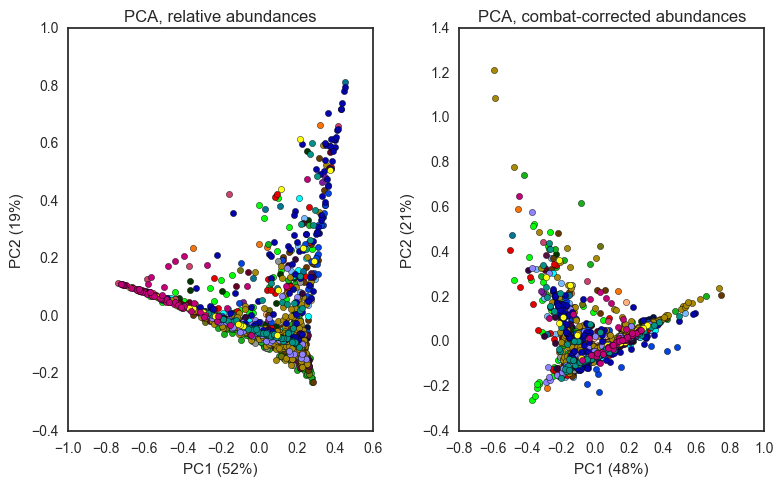

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(8,5))

for g, subdf in pca_abun_df.groupby('dataset'):
    ax[0].scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])
for g, subdf in pca_combat_df.groupby('dataset'):
    ax[1].scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])

ax[0].set_title('PCA, relative abundances')
ax[1].set_title('PCA, combat-corrected abundances')

ax[0].set_xlabel('PC1 ({:.0f}%)'.format(pca_abun.explained_variance_ratio_[0]*100))
ax[0].set_ylabel('PC2 ({:.0f}%)'.format(pca_abun.explained_variance_ratio_[1]*100))

ax[1].set_xlabel('PC1 ({:.0f}%)'.format(pca_combat.explained_variance_ratio_[0]*100))
ax[1].set_ylabel('PC2 ({:.0f}%)'.format(pca_combat.explained_variance_ratio_[1]*100))

plt.tight_layout()

### MDS

In [30]:
## MDS plot
from sklearn import manifold

n_components = 2

mds_abun = manifold.MDS(n_components, max_iter=100, n_init=1).fit_transform(healthy_df.values)
mds_combat = manifold.MDS(n_components, max_iter=100, n_init=1).fit_transform(combat_df.values)


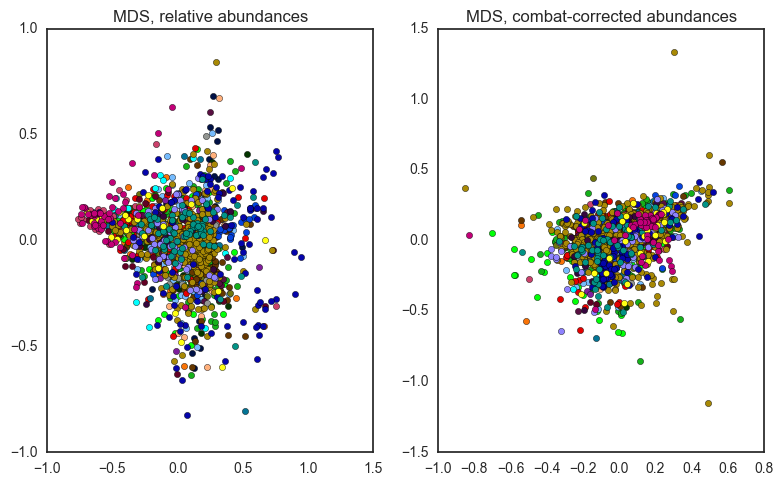

In [31]:
mds_abun_df = pd.DataFrame({'PC1': mds_abun[:, 0], 
                            'PC2': mds_abun[:, 1], 
                            'dataset': [i.split('-')[0] for i in healthy_df.index]})
mds_combat_df = pd.DataFrame({'PC1': mds_combat[:, 0], 
                              'PC2': mds_combat[:, 1], 
                              'dataset': [i.split('-')[0] for i in combat_df.index]})

fig, ax = plt.subplots(1, 2, figsize=(8,5))

for g, subdf in mds_abun_df.groupby('dataset'):
    ax[0].scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])
for g, subdf in mds_combat_df.groupby('dataset'):
    ax[1].scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])

ax[0].set_title('MDS, relative abundances')
ax[1].set_title('MDS, combat-corrected abundances')

plt.tight_layout()

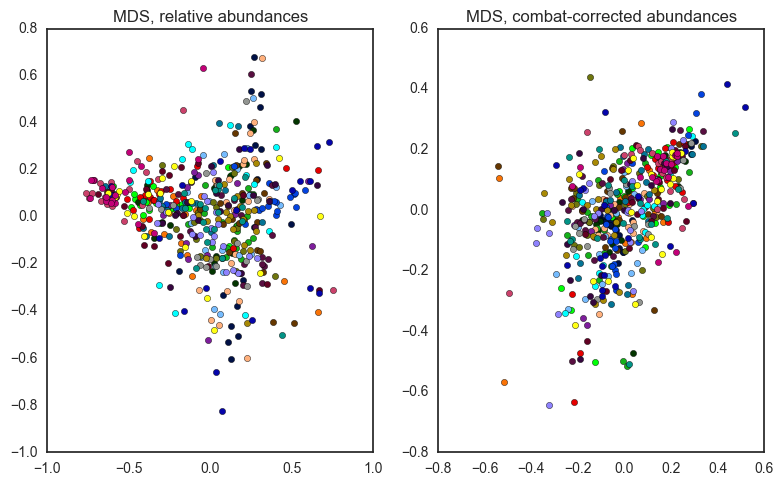

In [32]:
## Same plot, but subsample to N patients per study
N = 20
fig, ax = plt.subplots(1, 2, figsize=(8,5))

for g, subdf in mds_abun_df.groupby('dataset'):
    ax[0].scatter(subdf['PC1'][:N], subdf['PC2'][:N], c=paldict[g])
for g, subdf in mds_combat_df.groupby('dataset'):
    ax[1].scatter(subdf['PC1'][:N], subdf['PC2'][:N], c=paldict[g])

ax[0].set_title('MDS, relative abundances')
ax[1].set_title('MDS, combat-corrected abundances')

plt.tight_layout()

In [33]:
## Save these to text files and make plots with R, actually
mds_abun_df.to_csv('mds.healthy_samples.rel_abun.csv')
mds_combat_df.to_csv('mds.healthy_samples.combat_rel_abun.csv')